## CCU - literature overview

In [1]:
# Load some libraries for reading the data from the database and plotting 

import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

from django.db.models import Count, Sum

In [2]:
p = Project.objects.get(pk=106)
dos = DocOwnership.objects.filter(query__project=p,relevant__in=[1,2,3])
dos.count()


12838

In [3]:
ratings = pd.DataFrame.from_dict(list(dos.order_by('finish').values(
    'finish','user__username','relevant'
)))

ratings['cumsum']=ratings.index
ratings.head()


,finish,relevant,user__username,cumsum
0,2018-11-05 14:11:32.553465+00:00,1,vicl,0
1,2018-11-05 14:13:33.473189+00:00,2,vicl,1
2,2018-11-05 14:14:30.634022+00:00,2,vicl,2
3,2018-11-05 14:15:48.387171+00:00,2,vicl,3
4,2018-11-05 14:22:05.033141+00:00,1,vicl,4


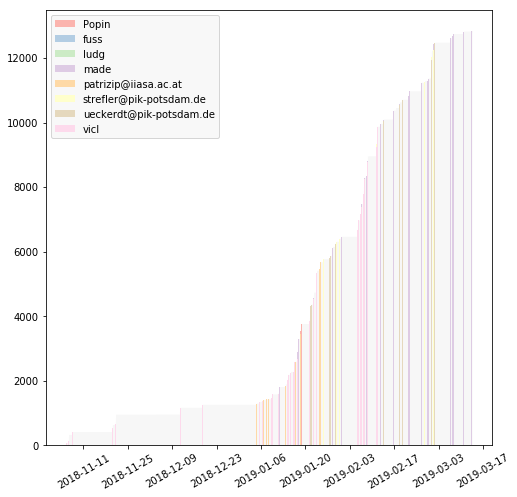

In [60]:
fig, ax = plt.subplots( figsize=(8,8))

times = [d.to_pydatetime() for d in ratings['finish']]

ax.fill_between(times,0,ratings['cumsum'],color="#f7f7f7")

markers = ('o','v','^','1','s','P','+','x','D')
cols = ["None","green","red","orange"]
cols = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec']
for i, (name, group) in enumerate(ratings.groupby('user__username')):
    times = [d.to_pydatetime() for d in group['finish']]
    ax.bar(
        times,
        group['cumsum'],
        label=name,
        width=0.2,
        color=cols[i]
        #s=15, 
        #marker=markers[i],
    )
    #ax.bar(times, group['cumsum'])
    
plt.setp(ax.get_xticklabels(), rotation=30)

plt.legend(facecolor="#f7f7f7")
plt.show()

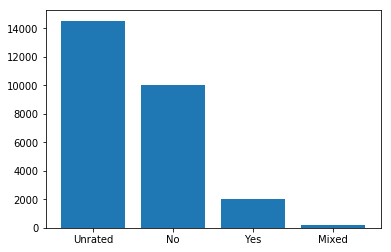

In [13]:
# How many documents are relevant or not
rel = list(Doc.objects.filter(docproject__project=p).values('docproject__relevant').annotate(
    n = Count('pk') # Count the pk - primary keys - of documents with each value
).order_by('-n'))

for r in rel: # get the full name of relevance
    r['relevant'] = DocProject.Relevance[r['docproject__relevant']][1]

# Put this into a dataframe
rel_df = pd.DataFrame.from_dict(rel) # we have to wrap the queryset in a list, so pandas can read it properly
rel_df.tail() # what do the last few rows look like?

fig, ax = plt.subplots()

ax.bar(rel_df.index,rel_df['n'])
ax.set_xticks(rel_df.index)
ax.set_xticklabels(rel_df['relevant'])

plt.show()

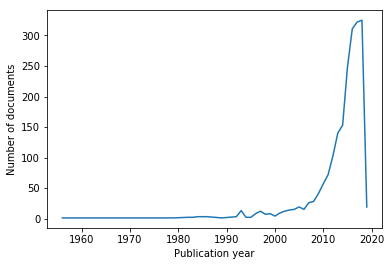

In [16]:
docs = Doc.objects.filter(docproject__project=p,docproject__relevant=1)
# how many documents in each year of each relevance category?
by_year = list(docs.values('PY').annotate(
    n = Count('pk') # Count the pk - primary keys - of documents in each value of PY (year)
).order_by('PY'))

# Put this into a dataframe
by_year_df = pd.DataFrame.from_dict(list(by_year)) # we have to wrap the queryset in a list, so pandas can read it properly

plt.plot(by_year_df['PY'],by_year_df['n'],label=name)
# Add some labels
plt.xlabel('Publication year')
plt.ylabel('Number of documents')

In [55]:
from utils.utils import ars

bypy = docs.filter(
       PY__in=range(1987,2019)
).values('PY').annotate(
    n = Count('UT', distinct=True)
).order_by('PY')

bypy = []
for py in range(1987,2019):
    for ar in ars:
        if py in ar['years']:
            pyd = {"PY": py}
            pyd['ar'] = ar['n']
            pyd['ar_name'] = ar['name']
            pyd['n'] = docs.filter(PY=py).count()
            bypy.append(pyd)

bypy = pd.DataFrame.from_dict(list(bypy))

bypy.head()

bypy.tail()

,PY,ar,ar_name,n
27,2014,6,AR6,153
28,2015,6,AR6,248
29,2016,6,AR6,311
30,2017,6,AR6,322
31,2018,6,AR6,325


In [56]:
doc_dict = []

ts = Category.objects.filter(project=p)

#allreldocs = Doc.objects.filter(query=q)
pys = list(range(1986,2019))
for t in ts:
    for py in pys:
        ydocs = docs.filter(PY=py)
        trdocs = set(list(ydocs.filter(
            query__category=t,docownership__relevant=1,docownership__query__category=t
        ).values_list('UT',flat=True)))
        ttdocs = set(list(ydocs.filter(
            category=t
        ).values_list('UT',flat=True)))
        tdocs = Doc.objects.filter(
            UT__in=trdocs.union(ttdocs)
        )
        d = {
            'Technology': t.name,
            'PY': py,
            'n': tdocs.count()
        }
        doc_dict.append(d)
        
for py in doc_dict:
    for ar in ars:
        if py['PY'] in ar['years']:
            py['ar'] = ar['n']
            py['ar_name'] = ar['name']

        
df = pd.DataFrame.from_dict(doc_dict)

techorder = list(ts.order_by('-ndocs').values_list('name',flat=True))


df['Technology'] = pd.Categorical(
    df['Technology'],
    techorder
)

df['ysum'] = df['n'].groupby(df['PY']).transform('sum')

df['share'] = df['n'] / df['ysum'] * 100

In [57]:

ardf = df[['Technology','ar_name','n']].groupby(['ar_name','Technology']).sum()

ardf = ardf.reset_index()

ardf['ysum'] = ardf['n'].groupby(ardf['ar_name']).transform('sum')

ardf['share'] = ardf['n'] / ardf['ysum'] * 100

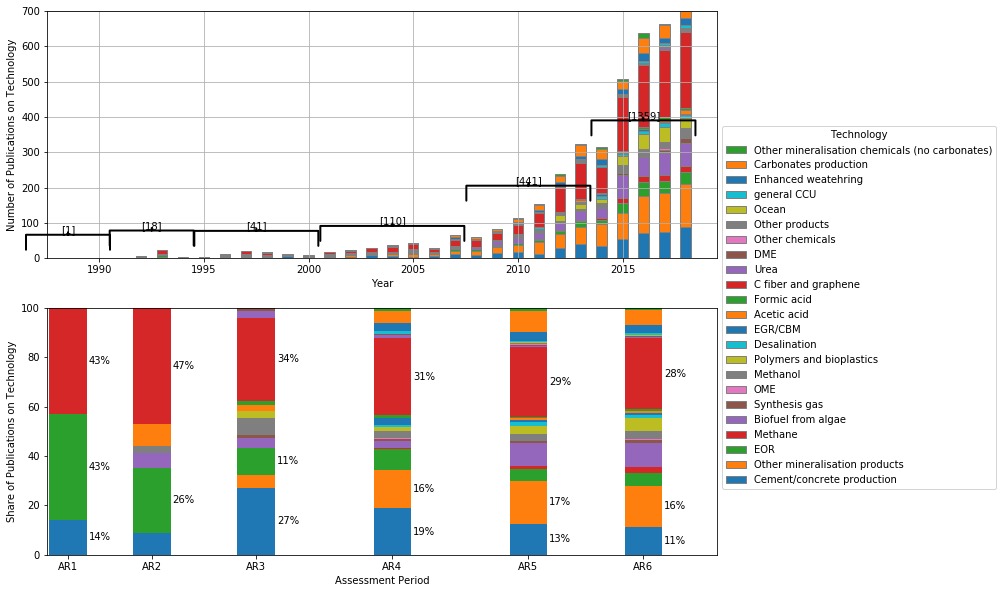

In [59]:
syear = 1986
xmin = 1.5


plt.rcParams["figure.figsize"] = [12,10]

fig, axs = plt.subplots(2,1)

ax = axs[0]

ax2 = axs[1]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)#.fillna(0)


pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'#,
    #align='center'
)



handles, labels = ax.get_legend_handles_labels()

ylabs = [1990,1995,2000,2005,2010,2015]
yts = [x-syear for x in ylabs]


ax.xaxis.set_ticks(yts)
ax.xaxis.set_ticklabels(ylabs)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.legend(handles[::-1], labels[::-1],title='Technology',loc="center left",bbox_to_anchor=(1, 1))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications on Technology')

ax.grid(True)

ax.set_xlim(xmax=2018-syear+1.5)
ax.set_xlim(xmin=xmin)
ax.set_ylim(ymax=700)

mids = []

for name, group in bypy.groupby('ar_name'):
    count = "[{}]".format(group['n'].sum())
    miny = group['PY'].min() - syear
    maxy = group['PY'].max() - syear
    width = maxy-miny + 1.2
    bwidth = 1.8
    mid = group['PY'].median() - syear
    mids.append(mid)
    maxn = group['n'].max() + 60
    #ax.text(mid,maxn,count,ha="center")
    ar = group['ar'].max()
    ax.annotate(
        count,
        xy=(mid,maxn),
        xytext=(mid,maxn+10),
        ha="center",
        arrowprops=dict(arrowstyle='-[, widthB={}, lengthB=1.5'.format(width), lw=2.0)
    )
    art = ardf[ardf['ar_name']==name]
    b = 0
    h = 0
    for t in techorder:
        v = art[art['Technology']==t]
        if not v.empty:
            v = float(v['share'])
            ax2.bar(
                mid,v,bottom=b,align="center",
                width=bwidth,color=handles[h].patches[0]._facecolor
            )        
            if v > 10:
                ax2.text(mid+bwidth*0.5+0.1,b+v*0.5,"{}%".format(round(v)),va="center")
            b+=v
        h+=1

ax = ax2

for tick in ax.get_xticklabels():
    tick.set_rotation(0)


#legend = plt.legend(position="right")#handles[::-1], labels[::-1],title='Technology')
#legend.remove()

ax.xaxis.set_ticks(mids)
ax.xaxis.set_ticklabels(["AR1","AR2","AR3","AR4","AR5","AR6"])

ax.set_xlabel('Assessment Period')
ax.set_ylabel('Share of Publications on Technology')

ax.set_xlim(xmax=2018-syear+1.5)
ax.set_xlim(xmin=xmin)

#plt.savefig('plots/general/all_ars.png',bbox_inches='tight') 
#plt.savefig('plots/general/all_ars.eps',bbox_inches='tight') 
#plt.savefig('plots/general/all_ars.svg',bbox_inches='tight') 

plt.show()


